## Convolutional Neural Networks

In the previous assignment we implemented a neural network using only numpy. We observed that as we added more components to the network (activations, regularization, batchnorm, etc.), the code became very complex and difficult to manage. In this assignment we will start with using the deep learning library, Pytorch that will modularize the components of a network and hide the complexity. 

The goal of this assignment is to become familiar with PyTorch and to build a neural network using PyTorch for FashionMnist data for Image classification. We have discussed in the lecture that the size of the model increases exponentially with the addition of fully connected layers. It would be impractical to build a deep neural network with only fully connected layers for images. In this assignment, we will build a Convolutional Neural Network that is the most popular approach to extracting features from an image without too much computation (compared to a fully connected layer). 

**It will be ideal to solve this assignemnet on a computer with a GPU**. The Coursera platform does not support a GPU. You may want to explore [Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow) or [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)

Along with submitting the Python notebook, save the notebook along with its output after executing all the cells as a .html file and submit the html file as well. 

We first import the neccesary packages required to build the model. We also fix a seed through out the process to have a deterministic behaviour (reproduce same results) of the model. 

In [4]:
## Imports
import os
import time
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy.testing as npt
#from torchsummary import summary
# from tqdm import trange

# Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 


working on gpu!


### Setting up the DataLoaders

In the following cell we will first download and arrange the data. FashionMNIST dataset is already available in the official PyTorch repository. Hence, the following cell checks for the availability of FashionMNIST data and downloads if the data is not available.   

The following parts are already written for you to handle the data.
- import neccesary pytorch packages for data handling.
- We then move the data onto PyTorch tensors.  
- Next we define the parameters like batch_size for data handling. A different batch_size for test data is used to     make sure that number of samples in the test data are perfectly divisible.
- create dataloaders for training and testing data to iterate.

In [5]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

# List of transformation on the data - here we will normalize the image data to (-1,1)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)),])
# Geta  handle to Load the data
training_data = torchvision.datasets.FashionMNIST(root, train=True, transform=transform,download=True)
testing_data = torchvision.datasets.FashionMNIST(root, train=False, transform=transform,download=True)

num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 60
test_bs = 50

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create Data loaders which we will use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs, 
    sampler=valid_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=test_bs, 
    drop_last=False)


### Visualize a Few Data Samples

In the following cell we first peek into a random batch of images together with labels and visualize them. 

torch.Size([60, 1, 28, 28])


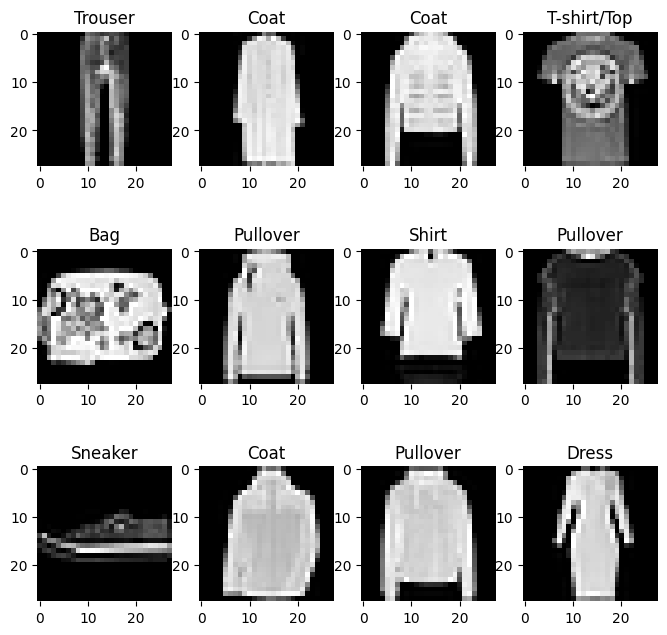

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## get a batch of data
images, labels = next(iter(train_loader))


image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
              4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
              8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

print(images.size())

for i in np.arange(1, 13):
    ax = fig.add_subplot(3,4,i, frameon=False)
    img = images[i][0]
    ax.set_title(image_dict[labels[i].item()])
    plt.imshow(img, cmap='gray')


### Architecture

We implement a Convolutional Neural Network as our model. We make use of the following layers in our model.
- a convolution layer for extracting features.
- batchnorm layer for normalizing the weights in the hidden layers.
- ReLU activation function for the non-linearity between layers.
- Finally fully connected layers in the end.

#### Model:

we make use of the following convolutional neural network architecture for our dataset. 

- convolution layer output_channels-16 kernel_size=3 stride=1 padding-1
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- convolution layer output_channels-32 kernel_size=3 stride=1 padding-1
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- convolution layer output_channels-64 kernel_size=5 stride=1 padding-2
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- fully connected layer - number_of_classes

### Build the model (30 points)

- We first define a class called Model nheriting from Pytorch's nn.Module.
- In init(constructor), we define all the layers that are used to build the model
- Define a forward function for a sequential model that takes in images as input and returns the predictions as output.

All the functions are available in the PyTorch package. Read the documentation/source code for a better understanding.

- Convolutional layer: https://pytorch.org/docs/stable/nn.html#convolution-layers
- Batchnorm layer: https://pytorch.org/docs/stable/nn.html#normalization-layers
- Activation ReLU: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
- Maxpooling layer: https://pytorch.org/docs/stable/nn.html#pooling-layers
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear-layers



In [50]:
import torch.nn as nn

class Model(nn.Module):
    ## init function is the constructor and we define all the layers used in our model. 
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        ''' 
        REST OF THE MODEL HERE
        
        # define a convolutional layer with 16 channels, kernel_size=3, stride=1 and padding=1
        
        # define a batchnormalization layer 
        
        # define a relu layer
        
        # define a maxpool layer with kernel_size=2, stride=2
        
        # define a convolutional layer with 32 channels, kernel_size=3, stride=1 and padding=1
        
        # define a batchnormalization layer 
        
        # define a relu layer
        
        # define a maxpool layer with kernel_size=2, stride=2
        
        # define a convolution layer with 64 channels, kernel_size=5, stride=1 and padding=2
        
        # define a batchnorm layer
        
        # define a relu layer
        
        # define a maxpool layer with kernel_size=2, stride=2
        
        # define a fully connected layer from resulting dimension -> number of classes
          
        
        '''
        # your code here
        c_in1 = 1
        c_out1 = 16
        kernel_size1 = 3
        stride1 = 1
        padding1 = 1
        maxpool1_k_size = 2
        maxpool1_stride = 2

        # define a convolutional layer with 16 channels, kernel_size=3, stride=1 and padding=1
        self.conv1 = nn.Conv2d(c_in1,c_out1,kernel_size1, stride1,padding1)
        self.bn1 = nn.BatchNorm2d(c_out1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(maxpool1_k_size,maxpool1_stride)


        c_in2 = c_out1
        c_out2 = 32
        kernel_size2 = 3
        stride2 = 1
        padding2 = 1
        maxpool2_k_size = 2
        maxpool2_stride = 2

        self.conv2 = nn.Conv2d(c_in2,c_out2,kernel_size2, stride2,padding2)
        self.bn2 = nn.BatchNorm2d(c_out2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(maxpool2_k_size,maxpool2_stride)
        
        c_in3 = c_out2
        c_out3 = 64
        kernel_size3 = 5
        stride3 = 1
        padding3 = 2
        maxpool3_k_size = 1
        maxpool3_stride = 2

        self.conv3 = nn.Conv2d(c_in3,c_out3,kernel_size3, stride3,padding3)
        self.bn3 = nn.BatchNorm2d(c_out3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(maxpool3_k_size,maxpool3_stride)
        
        
        # 64X4X4
        in_features = 1024
        out_features = num_classes
        self.fn = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        # We will start with feeding the data to the first layer. 
        # We take the output x and feed it back to the next layer 
        # your code here
        # Continue in ths manner to get the output of the final layer. 

        # First CONV layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        #print("1 - x_shape = ",np.shape(x))
        # Second CONV layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        #print("2 - x_shape = ",np.shape(x))
        # Third CONV layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        #print("3 - x_shape = ",np.shape(x))

        x = self.flatten(x)
        #print("4")
        #x = x.view()

        # Fully connected layer
        y = self.fn(x)  
        #print("5")
        return x
    
    # Note that before the fully connected(fc) layer, the output is a feature map with size (N,C,H,W)
    # but a fully connected layers expects a input of size (N, dimension). Therefore, before passing the output of
    # maxpool layer to the fc layer, we must first flatten the output of previous layer to a size (N,C*H*W) 
    # and then pass it to the fully connected layer, like x = x.flatten(x)
    # Define the flatten function below, use the x = x.view() function
    def flatten(self, x):
        N, C, H, W = x.size()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        # 16,64,4,4
        #print("DIMS")
        #print(N,C,H,W)
        #print("TYPE = ",type(x))
        #reshape x to (N, C*H*W) 
        #x = np.reshape(x,(N,C*H*W))
        #x = torch.flatten(x)
        x = x.view(N,C*H*W)
        #print(np.shape(temp))
        #print(x.shape)
        # your code here
        
        
        return x
        
        
    

In [51]:
## Run the cell to check the implementation of your model
# The testcase only tests the input and output dimensions of your architecture. 
# The only constraints you Model needs to satisfy are: 
# The Model object is initialized by providing num_classes as input 
# The network takes input Tensors of dimensions (B,1,28,28), where B is arbitrary batch_size, 
#    1 is the number of channels in the grayscale image and 28 is image size
# The output of the network is Tensor of dimensions (B,10) where 10 is the num_classes

model = Model(num_classes=10)
test_input1 = torch.randn(16,1,28,28)
out1 = model(test_input1)
test_input2 = torch.rand(20,1,28,28)
out2 = model(test_input2)

#hidden tests follow


In [ ]:
# Setting up a few learning parameters
learning_rate = 1e-2
decayRate = 0.999
epochs = 5
number_of_classes = 10

### Initialize the CNN Model (10 points)

Define a loss criterion, In this assignment we will use cross-entropy loss between the predictions and ground truth to estimate the loss. 
- CrossEntropyLoss - https://pytorch.org/docs/stable/nn.html#crossentropyloss

We also define a optimization strategy to update the weights. In this assignment we use the most commonly used Adam optimizer from the PyTorch package.

- Adam - https://pytorch.org/docs/stable/optim.html#algorithms 

In [ ]:
## First we will define an instance of the model to train
model = Model(num_classes=number_of_classes)
print(model)

#Move the model to the gpu if is_cuda
if is_cuda:
  model = model.cuda()

# define the loss 'criterion' as nn.CrossEntropyLoss() object
# criterion = 
# your code here


# Initialize the Adam optimizer for the model.parameters() using the learning_rate
# optimizer = 
# your code here


# This is the learning rate scheduler. It decreases the learning rate as we approach convergence
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# optimizer = None

In [ ]:
out = torch.FloatTensor([[0.1,0.8,0.05,0.05]])
true = torch.LongTensor([1])
assert criterion(out, true), 0.8925

### Training the Model (30 points)

The training loop is setup in the following way:

For every batch in the defined number of epochs

- Move the images and labels to the gpu by checking is_cuda
- Extract output by passing images through the model 
- pass the output and ground truth to the loss criterion for batch loss
- clear the gradients 
- backpropagate (compute gradients w.r.t the parameters) using backward() 
- update the parameters with a single optimization step
- update the training loss for plots

repeat

In [ ]:
## training loop 

## Number of epochs the model runs

def train_model(epochs=25, validate=True):
    '''
    A function to train the model on the dataset and returns the trained model, training loss and
    validation loss for every epoch.
    
    Inputs:
        epochs: Number of times the model should be trained on the whole data.
        validate: A boolean parameter that validates on validation data.
        
    Outputs:
        model: The model trained for specified number of epochs
        training loss: A list of training losses computed for every epoch.
        validation loss: A list of validation losses computed for every epoch.
    
    '''
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0
        
        # Move the images and labels to the gpu by checking is_cuda
        # Extract outputs by passing images through the model 
        # estimate loss using criterion(.) with 'outputs' and 'labels'
        # clear the gradients with .zero_grad()
        # Estimate gradients using .backward()
        # update model with .step()
        # update learning_rate with with a .step using my_lr_scheduler
        # add loss to training_loss
        model.train()
        itr = 0
        for (images,labels)  in train_loader:
            # your code here
            
            if itr%100 == 0:
                print('Epoch %d/%d, itr = %d, Train Loss = %.3f, LR = %.3E'\
                      %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
            itr += 1
        train_loss.append(training_loss/len(train_loader))
        print('------------------------------------------------')
        
        # During validation we do not update gradients. We set model to eval()
        # Move images and labels to gpu if is_cuda
        # get 'outputs' using model and images
        # estimate loss using criterion(.) with 'outputs' and 'labels'
        # add loss to 'validation_loss'
        if validate:
            model.eval()
            with torch.no_grad():
                itr = 0
                for (images,labels)  in valid_loader:
                    # your code here
                    
                    if itr%100 == 0:
                        print('Epoch %d/%d, itr = %d, Val Loss = %.3f, LR = %.3E'\
                              %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
                    itr += 1
                val_loss.append(validation_loss/len(valid_loader))
                print('################################################')
                
    return model, train_loss, val_loss
                

In [ ]:
start = time.time()
trained_model, train_loss, val_loss = train_model(epochs, validate=True)
end = time.time()
print('Time to train in seconds ',(end - start))

In [ ]:
# Test cases to ensure loss is reducing every epoch
# hidden test cases follow 

In [ ]:
# Plot the losses
it = np.arange(epochs)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

### Testing the Classsification (30 points)

In the testing loop we don't update the weights. The trained model is tested for all the samples in test data to compute the accuracy and observe how well the model is generalizing to the unseen data. 

The testing loop is setup in the following way: 

For every batch in the testing data

- Put the model in the evaluation mode and turn off the gradients
- Move the images and labels to the device available
- extract output from the model for the input
- compute the prediction class by choosing the one with maximum probability in the predictions.
- Compare the prediction classes with true classes.
- calculate accuracy
- update test_loss for plots

repeat


In [ ]:
## Testing Loop

def evaluate_model(model, loader):
    '''
    A function to test the trained model on the dataset and print the accuracy on the testset.
    
    Inputs:
        model: Trained model
        loader: train_loader or test_loader
        
    outputs:
        accuracy. returns the accuracy of prediction
    '''
    model.eval()
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for images, labels in loader:
            ## Move the images and labels to gpu if is_cuda 
            ## Get the output of the model by passing images as input to the model
            ## estimate the index of the highest output in each row, that is the predicted label 
            ## There is no need for softmax if the goal is to merely identify the predicted category
            ## compare predictions with ground truth for number of correct samples
            # your code here
            
            
            total_samples += labels.size(0)
        
        accuracy = correct/total_samples*100
        print("Total Accuracy on the Input set: {} %".format(accuracy))
        return accuracy

In [ ]:
# With these settings, obtained 95% train and 91% test accuracy
tr_acc = evaluate_model(model, train_loader)
ts_acc = evaluate_model(model, test_loader)
print('Train Accuracy = %.3f'%(tr_acc))
print('Test Accuracy = %.3f'%(ts_acc))

In [ ]:
# test cases for test accuracy > 90%
# hidden tests follow 

In [ ]:
## Visualize the test samples with predicted output and true output
images, labels = iter(test_loader).next()
# images = images.numpy()
if is_cuda:
  images = images.cuda()
  labels = labels.cuda()

out = model(images)
_, preds = torch.max(out, dim=1)

images = images.to('cpu').numpy()

fig = plt.figure(figsize=(15,15))
for i in np.arange(1, 13):
    ax = fig.add_subplot(4, 3, i)
    plt.imshow(images[i][0])
    ax.set_title("Predicted: {}/ Actual: {}".format(image_dict[preds[i].item()], image_dict[labels[i].item()]), 
                color=('green' if preds[i] == labels[i] else 'red'))

#### The assignment is graded both manually and using auto-graded testcases.